# ML and spectroscopy: toy applications

## Diatomic constants

We are implemementing a ML where a Random Forest model is used to predict the rovibrational energy level of CO , and then a Linear Regression model is used to approximate the molecular constants. The model performance is evaluated using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R$^2$.

Our dataset is originated using the equation: 

$$ E_{\text{rovib, anharmonic}}(v, J) = T_e +  \left( v + \frac{1}{2} \right) \omega_e - \left( v + \frac{1}{2} \right)^2 \omega_e x_e  + \left( B  - D_e J(J+1) \right) J(J+1) + \alpha_e J^2(J+1)^2$$

Where:
- $ T_e$ is the **electronic energy**.
- $ v $ is the **vibrational quantum number**.
- $ \omega_e$ is the **harmonic vibrational frequency**.
- $ \omega_e x_e $ is the **anharmonic correction** to the vibrational frequency.
- $ B $ is the **rotational constant** for the ground vibrational state (first rotational constant).
- $ D_e $ is the **centrifugal distortion constant**, which corrects the rotational energy levels for the elongation of the bond during rotation.
- $ J(J+1) $ is the **rotational energy term**, where \( J \) is the rotational quantum number.
- $ \alpha_e$ is the change in the rotational constant due to vibrational excitation. 



This exercise evaluates the model performance when the analytical data are perturbed  and recovers the  polynomial coefficients using Linear Regression after such perturbation. The scope is to provide insights into how well the Random Forest model learned the underlying structure. Molecular constants are taken from the [NIST webbook](https://webbook.nist.gov/cgi/cbook.cgi?ID=C630080&Mask=1000#Diatomic). 

In [1]:
!pip install tensorflow
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.6 MB/s eta 0:00:002.3 MB/s eta 0:00:01


Predicted Coefficients Train test:
a1: 2159.2465701954584
a2: 13.510130654540903
a3: 2.5656033593567322
a4: 0.015806816095210507
    
Predicted Coefficients Test set:
a1: 2188.2276115549735
a2: 12.701395215795518
a3: 4.465346983950993
a4: 0.01189478018207879
    
Estimation metrics:
Mean Squared Error: 903032.816481841
RMSE: 950.2803883495866
R^2 Score: 0.9982619959743638


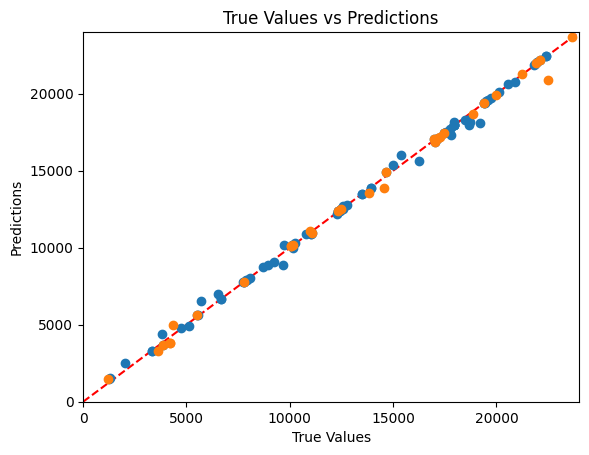

Difference in coefs /ratio
a1: -0.008486457880392408
a2: 0.04416775227282334
a3: -1.312116820144857
a4: 0.3204695169915016
    


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,root_mean_squared_error

def generate_data(num_samples=300):
    true_coefficients = [0.0,2169.81358,13.28831,1.93128087,0.01750441,6.12147e-06]  # Example coefficients for a0, a1, a2, a3, a4
    X1 = np.random.randint(0, 30, size=num_samples)
    X2 = np.random.randint(0, 30, size=num_samples)
    
    # Calculate output based on the new formula
    y = (true_coefficients[0] + 
         true_coefficients[1] * (X1 + 0.5) + 
         true_coefficients[2] * (X1 + 0.5)**2 + 
         (true_coefficients[3] + true_coefficients[5] * (X1 + 0.5)) * X2 * (X2 + 1) + 
         true_coefficients[4] * (X2**2) * (X2 + 1)**2)
    
    y += np.random.normal(0, 0.1, num_samples)  # Adding noise
    return np.column_stack((X1, X2)), y


# Generate data
X, y = generate_data(num_samples=400)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000)
rf_model.fit(X_train, y_train)
y_pred_rf_est = rf_model.predict(X_test)

# Step 4: Make predictions with the Random Forest model
y_pred_rf = rf_model.predict(X_train)

# Step 5: Fit a linear regression model to approximate the coefficients
# Create transformed features based on the original function
X_transformed = np.column_stack([
    (X_train[:, 0] + 0.5), 
    (X_train[:, 0] + 0.5) ** 2,
    X_train[:, 1] * (X_train[:, 1] + 1),
    (X_train[:, 1] ** 2) * (X_train[:, 1] + 1) ** 2
])

# Fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_transformed, y_pred_rf)

# Print the coefficients
predicted_coefficients = linear_model.coef_
print(f"Predicted Coefficients Train test:")
print(f"a1: {predicted_coefficients[0]}")
print(f"a2: {predicted_coefficients[1]}")
print(f"a3: {predicted_coefficients[2]}")
print(f"a4: {predicted_coefficients[3]}")
print(f"    ")

#############################################################################################################

# Step 5: Fit a linear regression model to approximate the coefficients
# Create transformed features based on the original function
X_transformed2 = np.column_stack([
    (X_test[:, 0] + 0.5), 
    (X_test[:, 0] + 0.5) ** 2,
    X_test[:, 1] * (X_test[:, 1] + 1),
    (X_test[:, 1] ** 2) * (X_test[:, 1] + 1) ** 2
])

# Fit the linear regression model
linear_model2 = LinearRegression()
linear_model2.fit(X_transformed2, y_pred_rf_est)

# Print the coefficients
predicted_coefficients2 = linear_model2.coef_
print(f"Predicted Coefficients Test set:")
print(f"a1: {predicted_coefficients2[0]}")
print(f"a2: {predicted_coefficients2[1]}")
print(f"a3: {predicted_coefficients2[2]}")
print(f"a4: {predicted_coefficients2[3]}")
print(f"    ")
#############################################################################################################

mse = mean_squared_error(y_test, y_pred_rf_est)
rmse= root_mean_squared_error(y_test, y_pred_rf_est)
r2 = r2_score(y_test, y_pred_rf_est)

print(f"Estimation metrics:")
print(f"Mean Squared Error: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")


# Visualise predictions 
plt.xlim(0,24000)
plt.ylim(0,24000)
plt.plot([0, 24000], [0, 24000], color='red', linestyle='--')
plt.plot( y_train,y_pred_rf,"o")
plt.plot( y_test,y_pred_rf_est,"o")

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()


true_coefficients = [0.0,2169.81358,13.28831,1.93128087,0.01750441,6.12147e-06]  # Example coefficients for a0, a1, a2, a3, a4

print(f"Difference in coefs /ratio")
print(f"a1: {(true_coefficients[1] - predicted_coefficients2[0])/true_coefficients[1]}")
print(f"a2: {(true_coefficients[2] - predicted_coefficients2[1])/true_coefficients[2]}")
print(f"a3: {(true_coefficients[3] - predicted_coefficients2[2])/true_coefficients[3]}")
print(f"a4: {(true_coefficients[4] - predicted_coefficients2[3])/true_coefficients[4]}")
print(f"    ")


we are attempting to apply Random Forest Regression to predict molecular energy levels  from the [ExoMol database](https://exomol.com/data/molecules/CO/12C-16O/Li2015/) based on the quantum numbers v and J and then use Linear Regression to approximate the coefficients of polynomial transformations of these features. 

**NB:** The ExoMol states file is in the following format. (Old format, see the [most recent paper](https://doi.org/10.48550/arXiv.2406.06347) for the formatting of more recent data - forehsadowing)
| Field                  | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| `i`                    | State ID                                                                    |
| $\tilde{E}$            | Recommended state energy in $\mathrm{cm^{-1}}$                              |
| $g_\mathrm{tot}$       | State degeneracy                                                            |
| $J$                    | Total angular momentum quantum number, $J$ or $F$ (integer/half-integer)    |
| Unc                    | Uncertainty in the state energy in $\mathrm{cm^{-1}}$                       |
| $\tau$                 | State lifetime (aggregated radiative and predissociative lifetimes) in s    |
| ($g$)                  | Landé $g$-factor (optional)                                                 |
| (QN)                   | State quantum numbers, may be several columns (optional)                    |


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_28427/1731577749.py:5: SyntaxWarning: invalid escape sequence '\s'
  CO=pd.read_csv("CO.txt",names=["idx","E","gns","J","v","e/f"],sep="\s+")


Predicted Coefficients:
a1: 1964.5610575666713
a2: -11.572443046632758
a3: 0.0018800231172154125
a4: 6.389661215600029e-05
    
Difference in coefs /ratio
a1: 0.09459454228013853
a2: 0.1291260478847379
a3: 0.9990265408069747
a4: 0.9963496848990626
Predicted Coefficients:
a1: 2044.7879986196854
a2: -13.164355441113438
a3: 0.0010460064454864693
a4: 6.530987482822326e-05
    
Difference in coefs /ratio
a1: 0.057620425336408224
a2: 0.009328090546244134
a3: 0.9994583871969454
a4: 0.9962689473779337


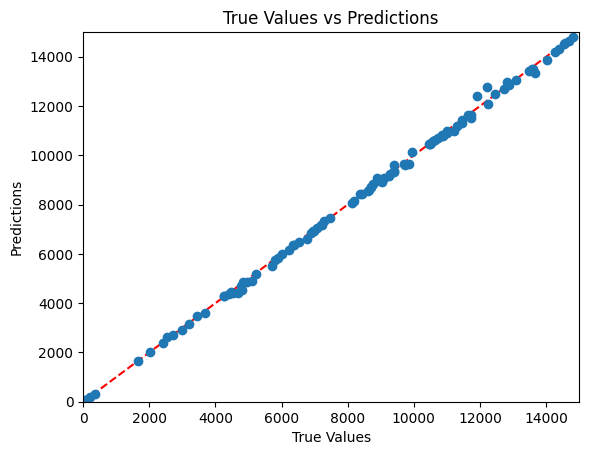

In [3]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

CO=pd.read_csv("CO.txt",names=["idx","E","gns","J","v","e/f"],sep="\s+")
X = CO[['v', 'J']].values
Y = CO['E'].values

for i in range(1,3):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
    rf_model = RandomForestRegressor(n_estimators=100)#,criterion="squared_error",oob_score=True,random_state=10)
    rf_model.fit(X_train, Y_train)

    y_pred_rf_est = rf_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_train)

    X_transformed = np.column_stack([
        (X_test[:, 0] + 0.5), 
        (X_test[:, 0] + 0.5) ** 2,
        (X_test[:, 1] * (X_test[:, 1] + 1) * (X_test[:, 0] + 0.5)),  # (a3 + a4 * (x1 + 0.5)) * x2 * (x2 + 1)
        (X_test[:, 1] ** 2) * (X_test[:, 1] + 1) ** 2  # a5 * (x2^2) * (x2 + 1)^2
    ])
# Fit the linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_transformed, y_pred_rf_est)
    predicted_coefficients = linear_model.coef_
#
#predicted_coefficients = linear_model.coef_
    print(f"Predicted Coefficients:")
    print(f"a1: {predicted_coefficients[0]}")
    print(f"a2: {predicted_coefficients[1]}")
    print(f"a3: {predicted_coefficients[2]}")
    print(f"a4: {predicted_coefficients[3]}")
    print(f"    ")

    print(f"Difference in coefs /ratio")
    print(f"a1: {(true_coefficients[1] - predicted_coefficients[0])/true_coefficients[1]}")
    print(f"a2: {(true_coefficients[2] - np.abs(predicted_coefficients[1]))/true_coefficients[2]}")
    print(f"a3: {(true_coefficients[3] - np.abs(predicted_coefficients[2]))/true_coefficients[3]}")
    print(f"a4: {(true_coefficients[4] - np.abs(predicted_coefficients[3]))/true_coefficients[4]}")
   #print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    #print(f"R^2 Score: {r2}")

# Optional: Visualize predictions (same as before)

plt.xlim(0,15000)
plt.ylim(0,15000)
plt.plot([0, 15000], [0, 15000], color='red', linestyle='--')
plt.plot( Y_test,y_pred_rf_est,"o")

#plt.plot( y_test,"o")

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()


In the following part, we use the polynomial regression and the PolynomialFeatures and LinearRegression classes from the scikit-learn library. We perform the  regression to predict the diatomic constants polynomial model and then extracting certain coefficients from the fitted polynomial model.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


# Step 2: Transform features
degree = 4  # Change this to fit a different degree polynomial
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X_test)

# Step 3: Fit the model
model = LinearRegression()
model.fit(X_poly, y_pred_rf_est)
predicted_coefficients = model.coef_

we=predicted_coefficients[1]
wexe=np.abs(predicted_coefficients[3])
Be=np.abs(predicted_coefficients[5])
ae=np.abs(predicted_coefficients[8])
De=np.abs(predicted_coefficients[14])

print(we,wexe,Be,De,ae,true_coefficients)
print(f"Difference in coefs /ratio")
print(f"we: {(true_coefficients[1] - we)/true_coefficients[1]}")
print(f"wexe: {(true_coefficients[2] - wexe)/true_coefficients[2]}")
print(f"BE: {(true_coefficients[3] - Be)/true_coefficients[3]}")
print(f"ae: {(true_coefficients[4] - ae)/true_coefficients[4]}")
print(f"De: {(true_coefficients[5] - De)/true_coefficients[5]}")

2161.704685410254 12.903019598727875 1.7393057475870755 1.6323339423252037e-05 0.019209030630471302 [0.0, 2169.81358, 13.28831, 1.93128087, 0.01750441, 6.12147e-06]
Difference in coefs /ratio
we: 0.003737138832795897
wexe: 0.028994687907802
BE: 0.09940300522571037
ae: -0.09738235281687875
De: -1.666571823965818


## Prediciting the water energy levels Using  Scikit-Learn + Tensorflow

The key quantum numbers that describe water's rotational energy levels are $v_1$, $v_2$, $v_3$, $J$, $K_a$, and $K_c$.

The **vibrational quantum numbers** include $v_1$, which refers to the symmetric stretching mode where the hydrogen atoms move symmetrically towards or away from the oxygen atom, $v_2$, which corresponds to the bending motion of the H-O-H bond angle, and $v_3$, which describes the asymmetric stretching mode, where one hydrogen atom moves towards the oxygen while the other moves away. For the **rotational quantum numbers**, $J$ represents the total rotational angular momentum of the molecule. $K_a$ and $K_c$ are projections of $J$ onto the principal axes of inertia, where $K_a$ refers to the projection along the axis with the intermediate moment of inertia, and $K_c$ refers to the projection along the axis with the smallest moment of inertia.

Obtaining energy levels and their corresponding quantum numbers is a challenging task that involves numerous experiments and calculations. These difficulties derives from the accuracy of the *ab initio* calculations required to solve the nuclear Schrödinger equation, which is necessary for determining the energy levels. Spectroscopy experiments provide the transition energies between different levels and their associated quantum numbers. By using combination differences on these transitions, the energy levels can then be assigned.

In this tutorial, we will explore the possibility of predicting the energy levels of molecules using the quantum numbers as inputs and the energy levels as outputs. The main goal is to produce a model that will be within chemical accuracy (below 350 cm$^{-1}$).


In [5]:
### Variables
l1=512
l2=256
size=0.2
dropout=0.2
rate=0.0005
l2norm=0.0002
epoch=100
wn2h=8065.54
#wn2h=219474.6313708
#wn2h=1

We will use scikit learn for the data preprocessing and tensorflow for the Neural Network. We will try to see what happens if we are using three different units: eV, Hartree or wavenumbes. 

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Load the data from a file
h2o = pd.read_csv('h2o.txt', sep="\s+")
h2o.drop("r",axis=1)
# Separate inputs (X), target (Y), and uncertainty (U)
X = h2o[['v1', 'v2', 'v3', 'J', 'Ka', 'Kc']].values
Y = h2o['E'].values
U = h2o['U'].values

Y=Y/wn2h
U=U/wn2h

# Handle zero uncertainty values: Set a minimum threshold to avoid division by zero
U[U == 0] = 1e-10  # You can choose a small value to replace zero uncertainty

# Split the data into training and testing sets
X_train, X_tmp, Y_train, Y_tmp, U_train, U_tmp = train_test_split(X, Y, U, test_size=0.2)#, random_state=42)
X_valid, X_test, Y_valid, Y_test, U_valid, U_test = train_test_split(X_tmp, Y_tmp, U_tmp, test_size=0.5)#, random_state=42)

# Normalize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

# Define a custom loss function that incorporates uncertainty
def weighted_mse_loss(y_true, y_pred, uncertainty):
    return tf.reduce_mean(((y_true - y_pred) ** 2) / (uncertainty ** 2))

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(l1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2norm)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(l2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2norm)),
    tf.keras.layers.Dense(1,activation='relu')#,activation='softmax')  # Output layer for regression
])

# Compile the model with a specified learning rate and custom loss function
learning_rate = rate
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=adam_optimizer,
              loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
print("Intra-op parallelism threads: ", tf.config.threading.get_intra_op_parallelism_threads())
print("Inter-op parallelism threads: ", tf.config.threading.get_inter_op_parallelism_threads())
# Train the model and pass sample weights
history=model.fit(X_train_scaled, Y_train, epochs=100, validation_data=(X_valid_scaled, Y_valid),callbacks=[early_stopping])

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Calculate overall MSE and MAE
overall_mse = mean_squared_error(Y_test, predictions)
overall_mae = mean_absolute_error(Y_test, predictions)

# Print overall results
print(f"Overall MSE: {overall_mse}")
print(f"Overall RMSE: {np.sqrt(overall_mse)}")
print(f"Overall MAE: {overall_mae}")

# Compute Pearson correlation between the true values and the predictions
correlation, p_value = pearsonr(Y_test, predictions.ravel())

# Print Pearson correlation
print(f"Pearson Correlation: {correlation}")
print(f"P-value: {p_value}")


<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_28427/3690855544.py:11: SyntaxWarning: invalid escape sequence '\s'
  h2o = pd.read_csv('h2o.txt', sep="\s+")
2024-11-23 16:29:48.291037: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-23 16:29:48.295719: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-23 16:29:48.308208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732375788.326880   28427 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732375788.331947   28427 cuda_blas.cc:1418] Unable to register cuBLAS factory: 

Intra-op parallelism threads:  0
Inter-op parallelism threads:  0
Epoch 1/100


2024-11-23 16:29:50.408684: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3008 - val_loss: 0.0523
Epoch 2/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0521 - val_loss: 0.0357
Epoch 3/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0354 - val_loss: 0.0245
Epoch 4/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0246 - val_loss: 0.0171
Epoch 5/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174 - val_loss: 0.0114
Epoch 6/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0083
Epoch 7/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0058
Epoch 8/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 9/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 10/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 11/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 12/100
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Plotting the Loss function as function of the Epoch helps to visualise possible overfitting issues.

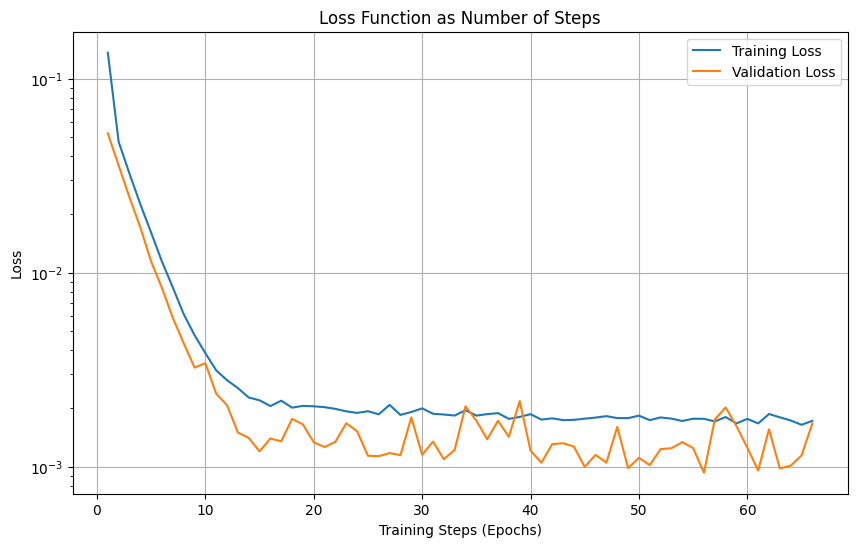

In [7]:
import matplotlib.pyplot as plt 

loss = history.history['loss']
val_loss = history.history['val_loss']
steps = range(1, len(loss) + 1)

# Plot the loss
plt.figure(figsize=(10, 6))
plt.yscale("log")

plt.plot(steps, loss, label='Training Loss')
plt.plot(steps, val_loss, label='Validation Loss')
plt.title('Loss Function as Number of Steps')
plt.xlabel('Training Steps (Epochs)')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [8]:
h2o=h2o.drop("r",axis=1)
h2o

,v1,v2,v3,J,Ka,Kc,E,U,n1,n2
0,0,0,0,0,0,0,0.000000,0.000000e+00,284,73
1,0,0,0,1,0,1,23.794361,2.515000e-07,868,91
2,0,0,0,1,1,1,37.137126,2.865000e-07,773,87
3,0,0,0,1,1,0,42.371746,2.531000e-07,769,92
4,0,0,0,2,0,2,70.090816,2.674000e-07,1092,97
...,...,...,...,...,...,...,...,...,...,...
18507,7,1,0,4,2,3,24214.970514,3.000000e-03,1,1
18508,1,2,5,4,3,1,24286.665880,3.000000e-03,1,1
18509,7,1,0,4,4,1,24378.801580,3.000000e-03,1,1
18510,7,1,0,6,2,5,24434.712521,3.000000e-03,1,1


**Skewness** is a statistical measure that quantifies the *asymmetry of the probability distribution* of a real-valued random variable about its mean. In the context of machine learning errors, skewness can provide insights into how the errors are distributed relative to the mean error.

**Kurtosis** is a statistical measure that describes the *shape of a probability distribution*, particularly the tails and the sharpness of the peak. In the context of machine learning errors, kurtosis helps understand the distribution's extremity, specifically how concentrated the values are around the mean and the presence of outliers.

Mean Error: 0.00
Standard Deviation of Error: 0.02
Skewness of Error: 0.84
Kurtosis of Error: 3.95


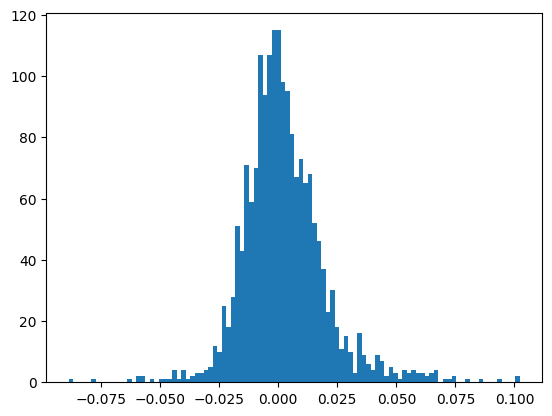

<Figure size 1000x600 with 0 Axes>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import scipy
# Calculate errors
errors = Y_test -predictions.flatten()
plt.hist(errors,bins=100)
# Plotting the error distribution
plt.figure(figsize=(10, 6))

# Calculate and display statistics
mean_error = np.mean(errors)
std_error = np.std(errors)

# Print statistics
print(f'Mean Error: {mean_error:.2f}')
print(f'Standard Deviation of Error: {std_error:.2f}')
print(f'Skewness of Error: {scipy.stats.skew(errors):.2f}')
print(f'Kurtosis of Error: {scipy.stats.kurtosis(errors):.2f}')


Small excursus, is there any form of info we can take trying to clustering the data?

Cluster Centers (Centroids):
 [[-0.28631979  0.67800005  0.97472048 -0.67900692 -0.381997   -0.46609759
   0.34675209 -0.14484854 -0.17276134 -0.26632536]
 [ 1.6791283  -0.10924365 -0.30040006 -0.778084   -0.45275867 -0.52223167
   0.85087049 -0.18281479 -0.16571175 -0.27984967]
 [-0.44728068 -0.41839261 -0.55728237  1.08047563  1.90459486 -0.27732809
   0.20852705  0.43207899 -0.20796652 -0.42359525]
 [-0.43719169 -0.17500759 -0.45182048 -0.33069392 -0.19467968 -0.21900726
  -1.29337992 -0.67500429  0.66254398  1.18209027]
 [-0.38262437 -0.27469843 -0.05597022  1.18870989 -0.40335472  1.65698196
   0.00662949  0.80572327 -0.19315459 -0.37408711]]
Cluster labels for each point: [3 3 3 ... 1 1 1]


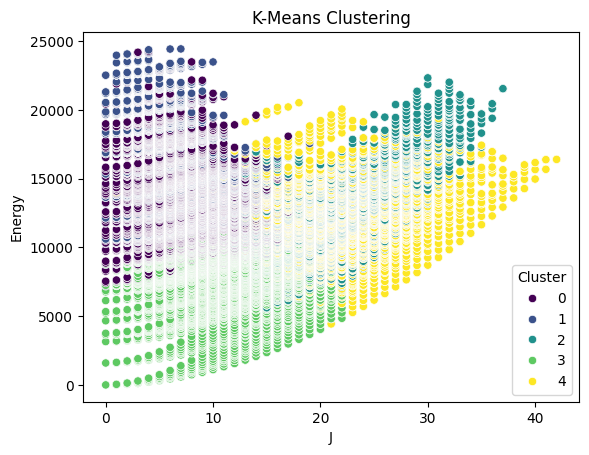

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Optionally, scale your features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(h2o)

# Define the number of clusters
n_clusters =5  # Set this to the desired number of clusters

# Create and fit the model
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(scaled_data)

# Create and fit the model
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(scaled_data)

# Get the cluster labels
labels = kmeans.labels_

# Add the labels to the original DataFrame
h2o['Cluster'] = labels

# Get the cluster centers (centroids)
print("Cluster Centers (Centroids):\n", kmeans.cluster_centers_)

# Check which cluster each data point belongs to
print("Cluster labels for each point:", kmeans.labels_)

# For a specific point, you can check its cluster

import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot for the first two features
#plt.xscale("log")
#plt.yscale("log")
#plt.figure(figsize=(10, 6))
sns.scatterplot(x=h2o['J'], y=h2o['E'], hue=h2o['Cluster'], palette='viridis')
plt.title('K-Means Clustering')
plt.xlabel('J')
plt.ylabel('Energy')
plt.show()


## Isotope shift predicition

Download the states file for an isotope of water, match the energy levels and calculate the difference between them.

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Load the data from a file
d2o = pd.read_csv('d2o.txt',sep=',')
h2o["E"]=h2o["E"]/wn2h
d2o["E"]=d2o["E"]/wn2h
water_intermediate = pd.merge(h2o, d2o, on=['v1', 'v2', 'v3','J','Ka','Kc'], suffixes=('_h2o', '_d2o'))
water_intermediate['delta'] =  water_intermediate['E_h2o'] - water_intermediate['E_d2o'] 
water = water_intermediate.drop(columns=['U','n1','n2','unc'])
#water = water[water['delta'] >= 0]
#plt.plot(water['delta'],'o')


We are usig delta as our target variable and C as our control variable 

In [12]:
# Separate inputs (X), target (Y),  and control (C)
X = water[['v1', 'v2', 'v3', 'J', 'Ka', 'Kc','E_h2o']].values
Y = water['delta'].values
C = water['E_d2o'].values

# Split the data into training and testing sets
X_train, X_tmp, Y_train, Y_tmp, C_train, C_tmp = train_test_split(X, Y, C,  test_size=0.2)
X_test, X_valid, Y_test, Y_valid, C_test, C_valid = train_test_split(X_tmp, Y_tmp, C_tmp,  test_size=0.1)

# Normalize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1,activation="relu")  # Output layer for regression
])

# Compile the model with a specified learning rate and custom loss function
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=adam_optimizer,
              loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and pass sample weights
history=model.fit(X_train_scaled, Y_train, epochs=100, validation_data=(X_valid_scaled, Y_valid),callbacks=[early_stopping]) 

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Calculate overall MSE and MAE
overall_mse = mean_squared_error(Y_test, predictions)
overall_mae = mean_absolute_error(Y_test, predictions)

# Print overall results
print(f"Overall MSE: {overall_mse}")
print(f"Overall MAE: {overall_mae}")

# Compute Pearson correlation between the true values and the predictions
correlation, p_value = pearsonr(Y_test, predictions.ravel())

# Print Pearson correlation
print(f"Pearson Correlation: {correlation}")
print(f"P-value: {p_value}")


Epoch 1/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2229 - val_loss: 0.0263
Epoch 2/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - val_loss: 0.0037
Epoch 3/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 4/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010 - val_loss: 6.6097e-04
Epoch 5/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5265e-04 - val_loss: 5.2710e-04
Epoch 6/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1314e-04 - val_loss: 5.2034e-04
Epoch 7/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4300e-04 - val_loss: 4.3997e-04
Epoch 8/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8372e-04 - val_loss: 4.5679e-04
Epoch 9/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6218e-04 - val_loss: 5.6933e-04
Epoch 10/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6046e-04 - val_loss: 4.5324e-04
Epoch 11/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.1819e-04 - va

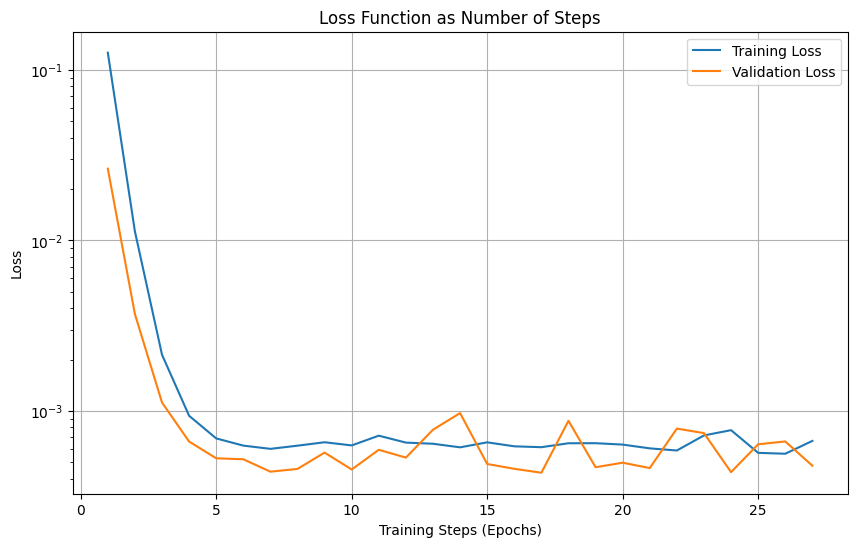

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
steps = range(1, len(loss) + 1)
# Plot the loss
plt.figure(figsize=(10, 6))
plt.yscale("log")

plt.plot(steps, loss, label='Training Loss')
plt.plot(steps, val_loss, label='Validation Loss')
plt.title('Loss Function as Number of Steps')
plt.xlabel('Training Steps (Epochs)')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Mean Error: 0.00
Standard Deviation of Error: 0.02
Skewness of Error: 1.09
Kurtosis of Error: 2.57


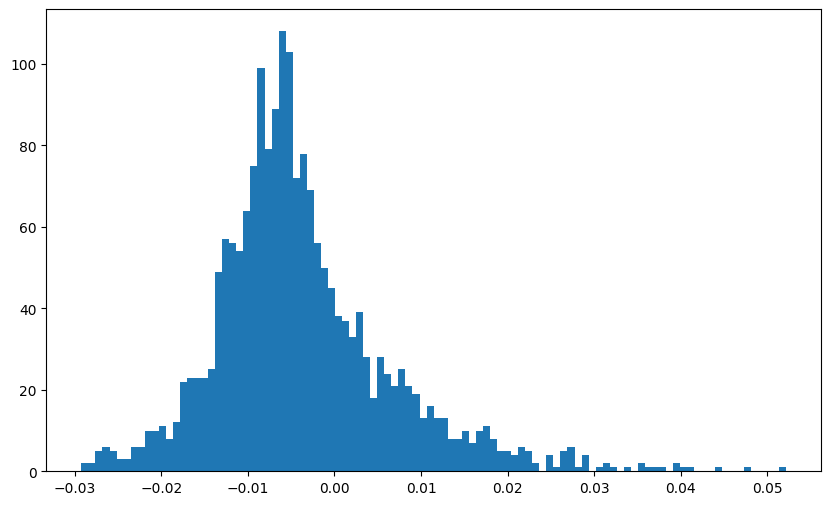

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
# Calculate errors
errors = Y_test -predictions.flatten()

# Plotting the error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors.flatten(),bins=100)

print(f'Mean Error: {mean_error:.2f}')
print(f'Standard Deviation of Error: {std_error:.2f}')
print(f'Skewness of Error: {scipy.stats.skew(errors):.2f}')
print(f'Kurtosis of Error: {scipy.stats.kurtosis(errors):.2f}')


Plot the predicted values vs the control. 

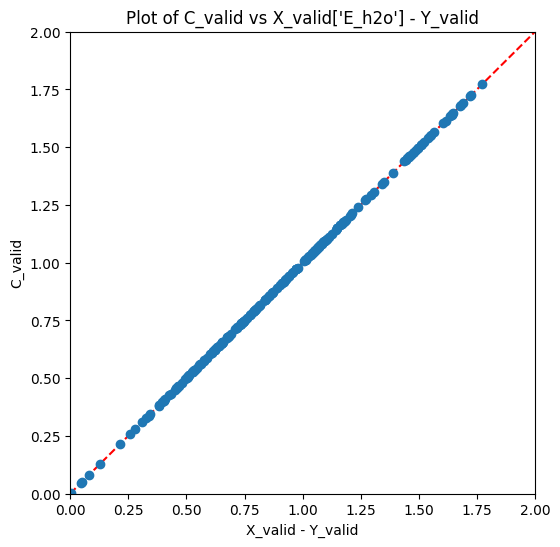

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'E_h2o' is the first column (index 0) of X_valid
E_h2o_valid = X_valid[:, 6] 

# Step 2: Add Y_valid to E_h2o_valid
X_valid_sum = E_h2o_valid - Y_valid

# Step 3: Plot C_valid against X_valid_sum
plt.figure(figsize=(6, 6))
plt.xlim(0,2)
plt.ylim(0,2)
plt.plot([0,3],[0,3],"--",color="red")
plt.plot(X_valid_sum, C_valid, 'o', label="C_valid vs X_valid['E_h2o'] + Y_valid")
plt.xlabel("X_valid - Y_valid")
plt.ylabel("C_valid")
plt.title("Plot of C_valid vs X_valid['E_h2o'] - Y_valid")
#plt.legend()
plt.show()


Plot the H$_2$O energy vs D$_2$O energy. 

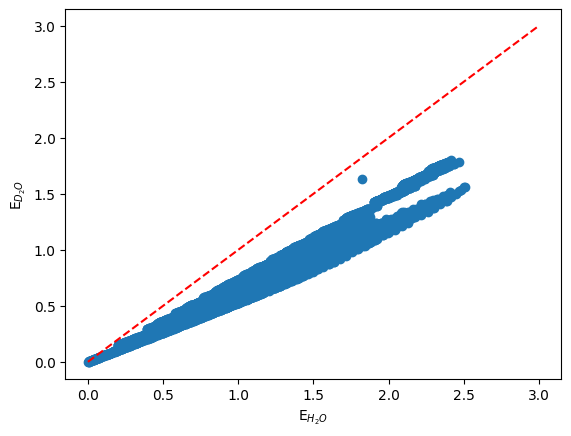

In [16]:
plt.plot(water["E_h2o"],water["E_d2o"], "o")
plt.xlabel("E$_{H_2O}$")
plt.ylabel("E$_{D_2O}$")
plt.plot([0,3],[0,3],"--",color="red")
